In [7]:
import psycopg2
from sshtunnel import SSHTunnelForwarder

import datetime as dt
import copy

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

import sys
sys.path.append('/home/anozdrin/Projects/operator-activity-visualizer')
import creds

In [8]:
with SSHTunnelForwarder(
    (creds.ssh_host_url, 10007),
    ssh_private_key = creds.ssh_path_to_key,
    ssh_private_key_password = creds.ssh_key_password,
    ssh_username = creds.ssh_username,
    remote_bind_address = ('localhost', 5432),
    local_bind_address = ('localhost', 5444)) as server:

    server.start()
    print ("ssh connection established")

    params = {
        'dbname': creds.db_name,
        'user': creds.db_user,
        'password': creds.db_password,
        'host': 'localhost',
        'port': 5444
    }
    
    conn = psycopg2.connect(**params)
    print ("db connection established")

    with conn:
        with conn.cursor() as curs:
            
            # Получаем все временные метки активности типа "Ожидание документа".
            curs.execute("""
                SELECT activity_date
                FROM operator_activity
                WHERE operator_id = '62db0936-1949-4c22-a7c2-754057870d3b'
                    AND activity_type='WAITING_DOCUMENT'
                    AND activity_date BETWEEN '2019-11-20' AND '2019-11-21'
                ORDER BY activity_date ASC;
            """)
            
            waiting_activity = curs.fetchall()
            
            # Получаем все временные метки активности типа "Действия в UI".
            curs.execute("""
                SELECT activity_date
                FROM operator_activity
                WHERE operator_id = '62db0936-1949-4c22-a7c2-754057870d3b'
                    AND activity_type='DOING_ACTIONS_IN_UI'
                    AND activity_date BETWEEN '2019-11-20' AND '2019-11-21'
                ORDER BY activity_date ASC;
            """)
            
            ui_activity = curs.fetchall()
            
            # Получаем все периоды, в которые у оператора был документ в обработке.
            curs.execute("""
                SELECT start_date, finish_date
                FROM document_operator
                WHERE operator_id = '62db0936-1949-4c22-a7c2-754057870d3b'
                    AND start_date BETWEEN '2019-11-20' AND '2019-11-21'
                ORDER BY start_date ASC;
            """)
            
            processing_activity_periods = curs.fetchall()
            
    conn.close()
    
    # a3ef9a04-bd7a-4b63-8e2d-a891516debdb

ssh connection established
db connection established


In [9]:
# Функция принимает массив timestamp'ов ("активностей") и возвращает периоды, в пределах которых промежутки 
# между активностями не превышают заданное значение в секундах.

def get_dense_activity_periods(activity, seconds):
    dense_periods = []

    period = [activity[0][0]]

    for i in range(len(activity)-1):
  
        if (activity[i+1][0] - activity[i][0]).total_seconds() < seconds:
            continue
        else:
            period.append(activity[i][0])
            print(period)
            dense_periods.append(period)
            period = []
            period.append(activity[i+1][0])
        
    period.append(activity[len(activity)-1][0])
    dense_periods.append(period)
    
    return dense_periods

In [10]:
# Получаем периоды, в которые оператора сидел и ждал документа.

waiting_periods = get_dense_activity_periods(waiting_activity, 10)
ui_activity_periods = get_dense_activity_periods(ui_activity, 5)

# Вынужденно преобразуем list of tuples в list of lists.

processing_activity_periods = [list(i) for i in processing_activity_periods]

[datetime.datetime(2019, 11, 20, 7, 58, 43, 168000), datetime.datetime(2019, 11, 20, 7, 59, 25, 367000)]
[datetime.datetime(2019, 11, 20, 8, 1, 3, 433000), datetime.datetime(2019, 11, 20, 8, 20, 57, 40000)]
[datetime.datetime(2019, 11, 20, 8, 21, 44, 979000), datetime.datetime(2019, 11, 20, 8, 37, 15, 686000)]
[datetime.datetime(2019, 11, 20, 8, 37, 40, 887000), datetime.datetime(2019, 11, 20, 9, 11, 28, 790000)]
[datetime.datetime(2019, 11, 20, 9, 12, 1, 65000), datetime.datetime(2019, 11, 20, 9, 12, 37, 221000)]
[datetime.datetime(2019, 11, 20, 9, 13, 14, 919000), datetime.datetime(2019, 11, 20, 9, 13, 45, 40000)]
[datetime.datetime(2019, 11, 20, 9, 14, 46, 541000), datetime.datetime(2019, 11, 20, 9, 29, 1, 486000)]
[datetime.datetime(2019, 11, 20, 9, 33, 25, 628000), datetime.datetime(2019, 11, 20, 9, 34, 34, 483000)]
[datetime.datetime(2019, 11, 20, 9, 36, 13, 37000), datetime.datetime(2019, 11, 20, 9, 47, 31, 481000)]
[datetime.datetime(2019, 11, 20, 10, 0, 59, 335000), datetime.d

In [11]:
# Дописываем метки к каждому набору данных, чтобы затем использовать их при построении графика.

for i in ui_activity_periods:
    i.append('ui')
for i in waiting_periods:
    i.append('wait')
for i in list(processing_activity_periods):
    i.append('process')
    
# Собираем все три набора в один массив.

activities_log = ui_activity_periods + waiting_periods + processing_activity_periods

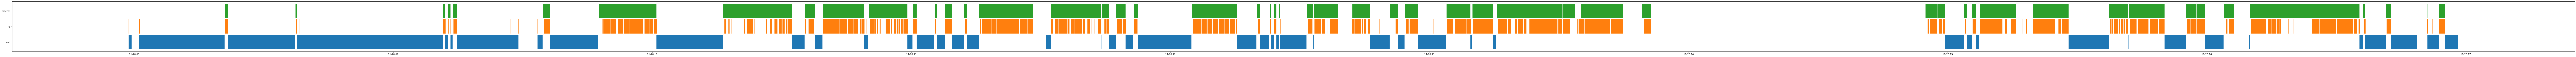

In [12]:
# Рисуем график.

cats = {"wait" : 1, "ui" : 2, "process" : 3}
colormapping = {"wait" : "C0", "ui" : "C1", "process": "C2"}

verts = []
colors = []

for d in activities_log:
    v =  [(mdates.date2num(d[0]), cats[d[2]]-.45),
          (mdates.date2num(d[0]), cats[d[2]]+.45),
          (mdates.date2num(d[1]), cats[d[2]]+.45),
          (mdates.date2num(d[1]), cats[d[2]]-.45)]
    
    verts.append(v)
    colors.append(colormapping[d[2]])

bars = PolyCollection(verts, facecolors=colors)

fig, ax = plt.subplots(figsize=(200,4))
ax.add_collection(bars)
ax.autoscale()

loc = mdates.HourLocator(interval=1)

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

ax.set_yticks([1,2,3])
ax.set_yticklabels(["wait", "ui", "process"])

plt.show()

In [ ]:
# Эта функция будет использоваться в будущем для текстового представления временных периодов.

def to_date(seconds):
    seconds = seconds - 10800
    timest = datetime.datetime.fromtimestamp(seconds)
    str_date = timest.strftime('%Y-%m-%d %H:%M:%S')
    return str_date